> Autor: Fabian Massotto

---

## Objetivo
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en images a partir del template.

1. Obtener una detección del logo en cada imagen sin falsos positivos.
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1.
3. Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Función para mostrar imágenes
def print_image(img):
    plt.figure(1)
    plt.imshow(img)
    plt.show()

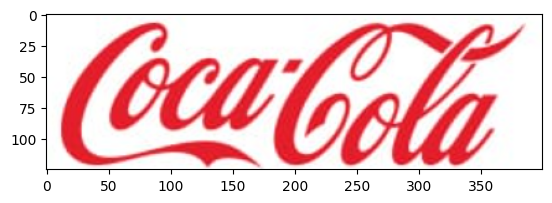

In [169]:
# Cargo la imagen que se va a utilizar como template
template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)

# Recorto margenes blancos innecesarios
template = template[25:150, 0:400]

print_image(template)

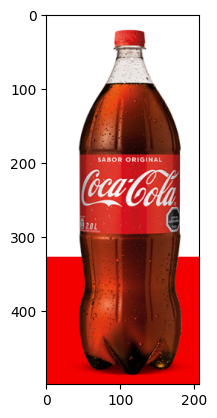

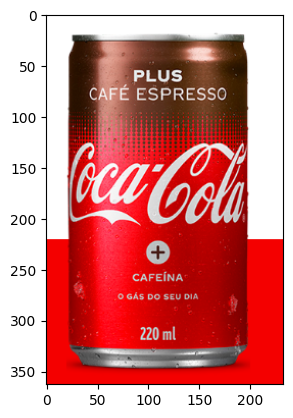

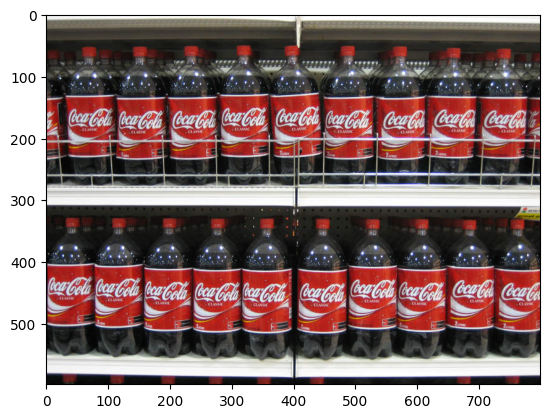

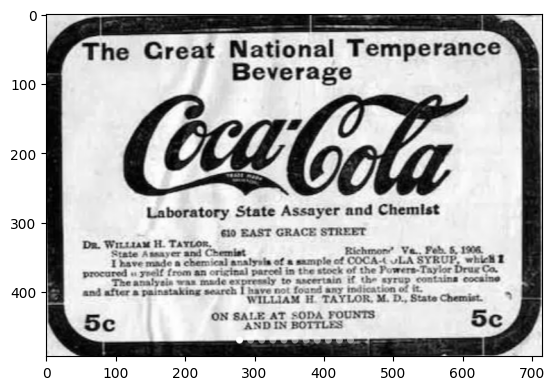

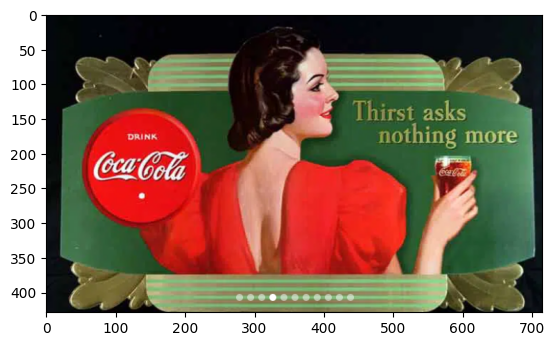

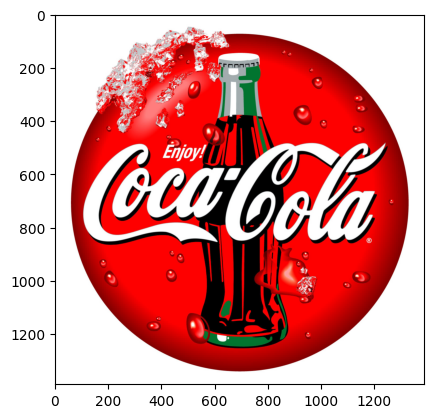

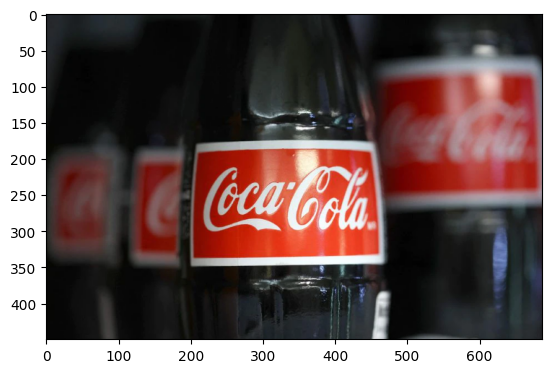

In [4]:
# Cargo las imágenes donde queremos encontrar el logo
files = ['coca_logo_1.png', 'coca_logo_2.png', 'coca_multi.png', 'coca_retro_1.png', 'coca_retro_2.png', 'COCA-COLA-LOGO.jpg', 'logo_1.png']
images = []

for file in files:
    img = cv.cvtColor(cv.imread(f'images/{file}'), cv.COLOR_BGR2RGB)
    print_image(img)
    images.append(img)

In [165]:
# Función para encontrar el template en una imagen
# Si se le pase debug=True se muestra el template que hizo match y las imagenes de bordes
def match_template(image, template, debug=False):
    img_salida = image.copy()

    # Hago primero un suavizado para blurrear detalles muy específicos (noté que mejora la extracción de bordes)
    image_blurred = cv.GaussianBlur(image,(9,9),0)
    # Aplico Canny para obtener los bordes de la imagen
    image_borders = cv.Canny(image_blurred, 50, 150)

    # Obtengo el ancho de la imagen
    w_image = image.shape[1]

    # Este modificador se utilizará para ir cambiando el tamaño del template
    template_size_modifier = 0.2

    # Escalo el template
    template_resized = cv.resize(template, None, fx=template_size_modifier, fy=template_size_modifier)
    w_template = template_resized.shape[1]

    # Variables para guardar las condiciones del mejor match
    best_val = 0
    best_loc = None
    best_template = None
    best_mod = None

    # Incremento el tamaño del template hasta que su ancho coincide con el de la imagen
    while w_template <= w_image:
        
        # Obtengo los bordes del template
        template_borders = cv.Canny(template_resized, 50, 150)

        # Hago un refuerzo de bordes (note que mejora los resultados, especialmente al agrandar el template)
        if template_size_modifier < 1:
            kernel = np.ones((3, 3), np.uint8)
            template_borders = cv.dilate(template_borders, kernel, iterations=1)
        elif template_size_modifier >= 1 and template_size_modifier < 2: 
            kernel = np.ones((5, 5), np.uint8)
            template_borders = cv.dilate(template_borders, kernel, iterations=1)
        else:
            kernel = np.ones((9, 9), np.uint8)
            template_borders = cv.dilate(template_borders, kernel, iterations=1)
        
        # Aplico template matching. Como ya pre-procese las imágenes para obtener los bordes, utilizo el coeficiente de correlación normalizado (para además obtener un nivel de confianza).
        res = cv.matchTemplate(image_borders, template_borders, cv.TM_CCORR_NORMED)
 
        # Aplico una segunda normalización utilizando Z-score lo cual ayuda a resaltar los picos en el resultado de template matching
        res_norm = (res-np.mean(res))/np.std(res)
        
        # Encontramos los valores máximos y mínimos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res_norm)
        
        # Verifico si es un mejor match
        if max_val > best_val:
            best_val = max_val
            best_loc = max_loc
            best_template = (template_borders, template_resized)
            best_mod = template_size_modifier
            best_conf = res[max_loc[1], max_loc[0]]

        # Escalo el template
        template_size_modifier += 0.05
        template_resized = cv.resize(template, None, fx=template_size_modifier, fy=template_size_modifier)
        w_template = template_resized.shape[1]
        
    if debug:
        print("Template size modifier: ", best_mod)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(best_template[1])
        axes[0].axis('off')
        axes[0].set_title('Template')

        axes[1].imshow(best_template[0])
        axes[1].axis('off')
        axes[1].set_title("Bordes")

        plt.show()

        print_image(image_borders)

    
    # Marcamos el lugar donde encontramos el template
    top_left = best_loc
    bottom_right = (top_left[0] + best_template[0].shape[1], top_left[1] + best_template[0].shape[0])
    cv.rectangle(img_salida, top_left, bottom_right, (0,255,0), 2)
    text_size =  3 if best_mod>1.5 else 0.8
    cv.putText(img_salida, f'{str(int(best_conf*100))}%', (top_left[0],top_left[1]-5), cv.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), 2, cv.LINE_AA)
    

    return img_salida, best_val

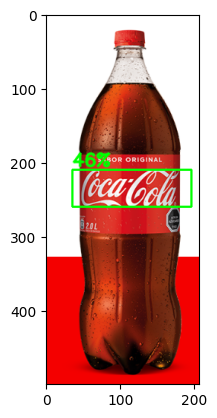

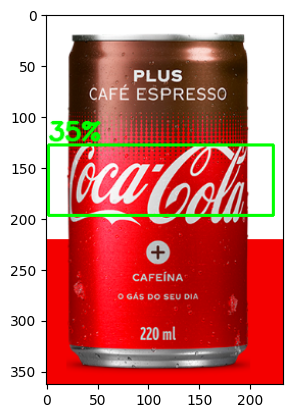

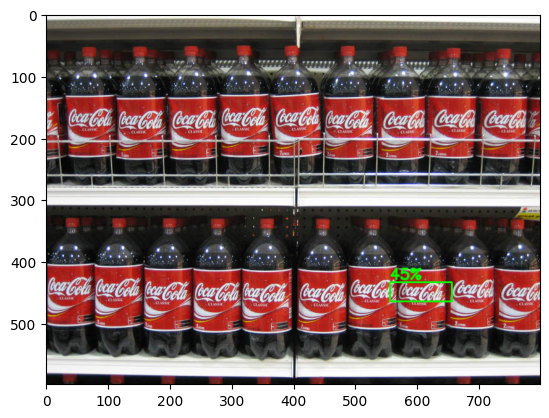

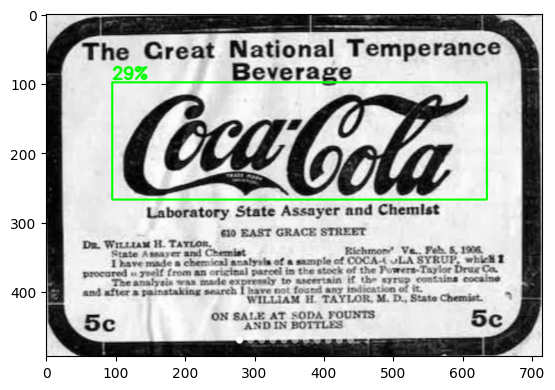

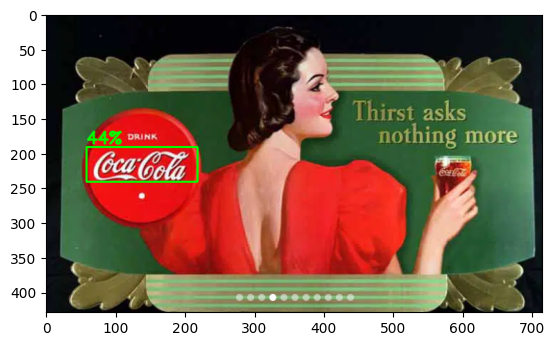

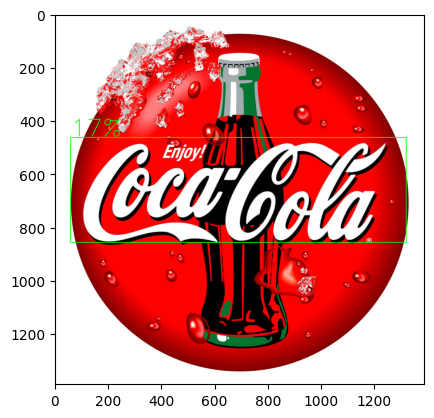

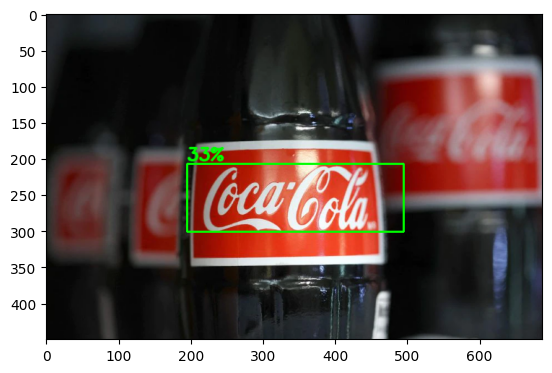

In [170]:
for img in images:
    print_image(match_template(img, template, debug=False)[0])

In [194]:
# Función para encontrar el template en una imagen, multiples veces
def match_template_multiple(image, template, nms=True):
    img_salida = image.copy()

    # Hago primero un suavizado para blurrear detalles muy específicos (noté que mejora la extracción de bordes)
    image_blurred = cv.GaussianBlur(image,(9,9),0)
    # Aplico Canny para obtener los bordes de la imagen
    image_borders = cv.Canny(image_blurred, 50, 150)

    # Obtengo el ancho de la imagen
    w_image = image.shape[1]

    # Este modificador se utilizará para ir cambiando el tamaño del template
    template_size_modifier = 0.2

    # Escalo el template
    template_resized = cv.resize(template, None, fx=template_size_modifier, fy=template_size_modifier)
    w_template = template_resized.shape[1]

    # Listas para guardar las condiciones de los diferentes matches
    boxes = []
    scores = []
    sizes = []
    
    # Obtengo la mejor coincidencia
    best_val = match_template(image, template, debug=False)[1]

    # Incremento el tamaño del template hasta que su ancho coincide con el de la imagen
    while w_template <= w_image:
        
        # Obtengo los bordes del template
        template_borders = cv.Canny(template_resized, 50, 150)
        
        # Hago un refuerzo de bordes (note que mejora los resultados, especialmente al agrandar el template)
        if template_size_modifier < 1:
            kernel = np.ones((3, 3), np.uint8)
            template_borders = cv.dilate(template_borders, kernel, iterations=1)
        elif template_size_modifier >= 1 and template_size_modifier < 2: 
            kernel = np.ones((5, 5), np.uint8)
            template_borders = cv.dilate(template_borders, kernel, iterations=1)
        else:
            kernel = np.ones((9, 9), np.uint8)
            template_borders = cv.dilate(template_borders, kernel, iterations=1)
            
        # Aplico template matching. Como ya pre-procese las imágenes para obtener los bordes, utilizo el coeficiente de correlación normalizado (para además obtener un nivel de confianza).
        res = cv.matchTemplate(image_borders, template_borders, cv.TM_CCORR_NORMED)
 
        # Aplico una segunda normalización utilizando Z-score lo cual ayuda a resaltar los picos en el resultado de template matching
        res_norm = (res-np.mean(res))/np.std(res)
        
        # Encontramos los puntos que superan el valor de threshold (utilizo el mejor valor - el 10%)
        threshold = best_val*0.9
        loc = np.where(res_norm >= threshold)
        for point in zip(*loc[::-1]): 
            top_left = (point[0], point[1])
            bottom_right = (top_left[0] + template_resized.shape[1], top_left[1] + template_resized.shape[0])
            boxes.append([top_left[0], top_left[1], bottom_right[0], bottom_right[1]])
            scores.append(res[point[1]][point[0]])
            sizes.append(template_size_modifier)
            
        # Escalo el template
        template_size_modifier += 0.05
        template_resized = cv.resize(template, None, fx=template_size_modifier, fy=template_size_modifier)
        w_template = template_resized.shape[1]

    if nms:
        indices = cv.dnn.NMSBoxes(boxes, scores, score_threshold=0.1, nms_threshold=0.5)
        for i in indices:
            top_left = (boxes[i][0], boxes[i][1])
            bottom_right = (boxes[i][2], boxes[i][3])
            cv.rectangle(img_salida, top_left, bottom_right, (0,255,0), 2)
            text_size =  3 if sizes[i]>1.5 else 0.8
            cv.putText(img_salida, f'{str(int(scores[i]*100))}%', (top_left[0],top_left[1]-5), cv.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), 2, cv.LINE_AA)
    else:
        for i, box in enumerate(boxes):
            top_left = (box[0], box[1])
            bottom_right = (box[2], box[3])
            cv.rectangle(img_salida, top_left, bottom_right, (0,255,0), 2)
            text_size =  3 if sizes[i]>1.5 else 0.8
            cv.putText(img_salida, f'{str(int(scores[i]*100))}%', (top_left[0],top_left[1]-5), cv.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0), 2, cv.LINE_AA)


    return img_salida

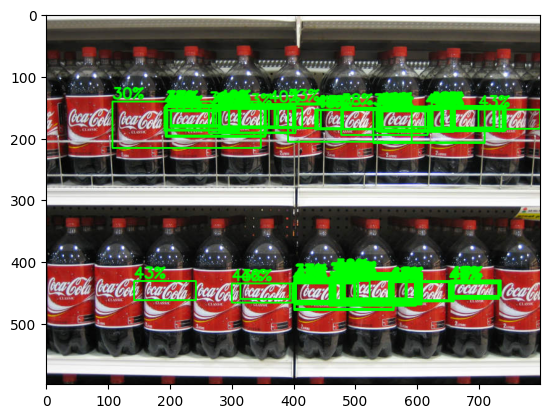

In [190]:
print_image(match_template_multiple(images[2], template, nms=False))

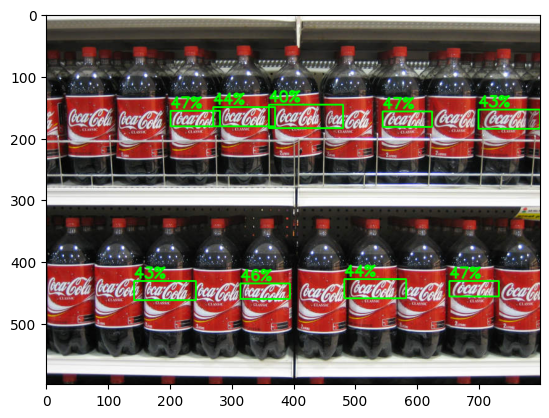

In [195]:
# Aplicando Non-Maximum Suppression (NMS) para eliminar las redundancias
print_image(match_template_multiple(images[2], template, nms=True))

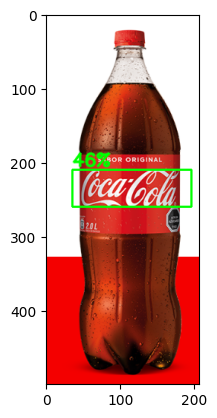

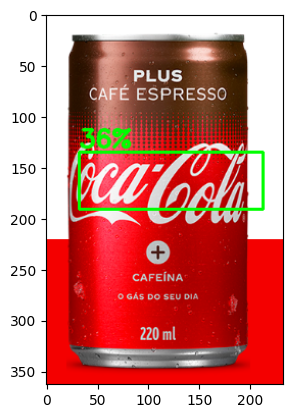

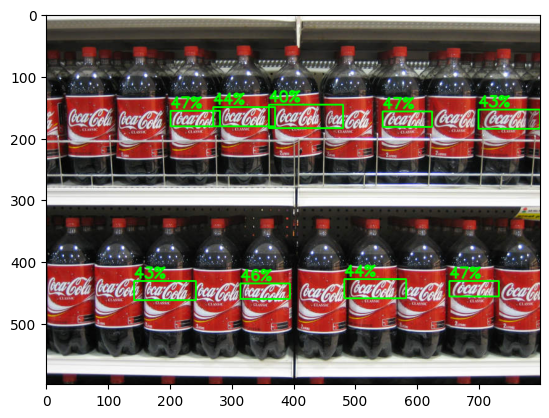

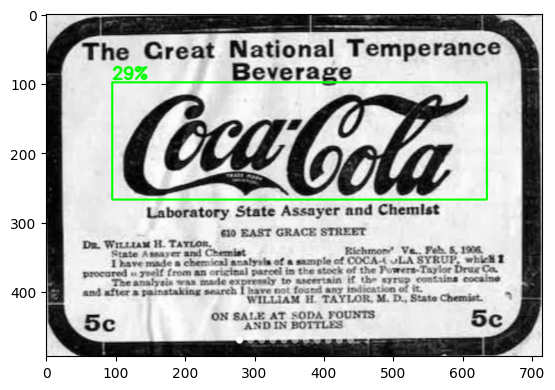

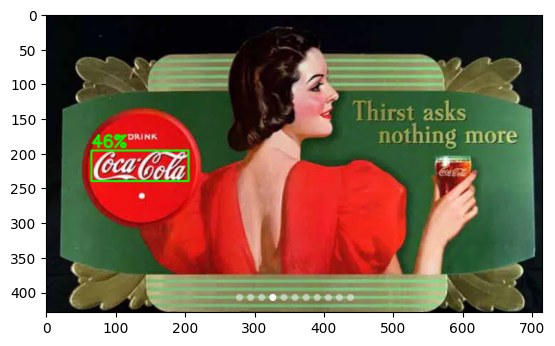

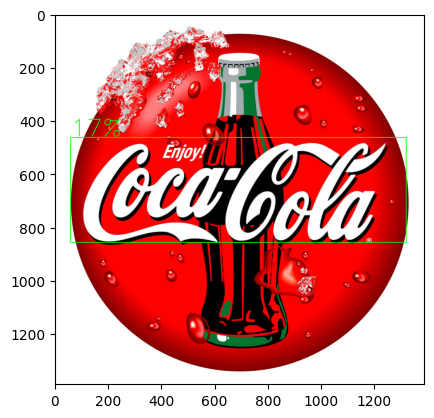

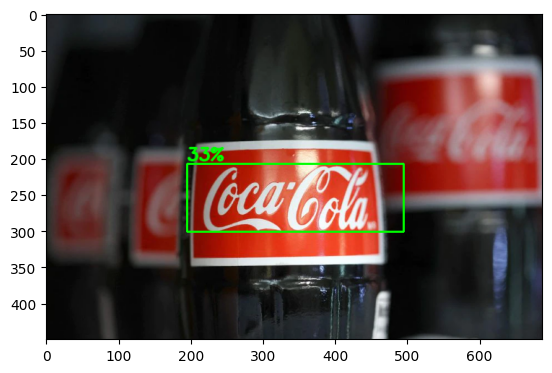

In [196]:
for i, img in enumerate(images):
    print_image(match_template_multiple(img, template, nms=True))